In [ ]:
!pip install fastf1

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [5]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import json
from google.colab import files

In [6]:
# Get rid of an error
pd.options.mode.chained_assignment = None

In [8]:
# Load the session data
race = ff1.get_session(2022, 'Abu Dhabi', 'R')

# Get the laps
laps = race.load_laps()

In [9]:
# Convert laptimes to seconds
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

# To get accurate laps only, we exclude in- and outlaps
laps = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]

In [10]:
# Also, we remove outliers since those don't represent the racepace,
# using the Inter-Quartile Range (IQR) proximity rule
q75, q25 = laps['LapTimeSeconds'].quantile(0.75), laps['LapTimeSeconds'].quantile(0.25)

intr_qr = q75 - q25

laptime_max = q75 + (1.5 * intr_qr) # IQR proximity rule: Max = q75 + 1,5 * IQR
laptime_min = q25 - (1.5 * intr_qr) # IQR proximity rule: Min = q25 + 1,5 * IQR

laps.loc[laps['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
laps.loc[laps['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

In [11]:
drivers_to_visualize = ['VER', 'PER', 'HAM', 'RUS', 'LEC', 'SAI']

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s = str(s)


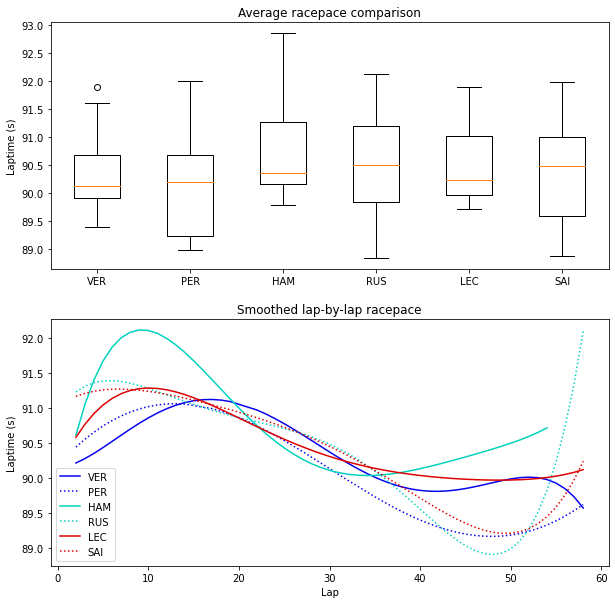

In [12]:
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [10, 10]

# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)


##############################
#
# Boxplot for average racepace
#
##############################
laptimes = [laps.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize)

ax[0].set_title('Average racepace comparison')
ax[0].set(ylabel = 'Laptime (s)')



##############################
#
# Lap-by-lap racepace comparison
#
##############################
for driver in drivers_to_visualize:
    driver_laps = laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle)
    
    # Include scatterplot (individual laptimes)
    # y = driver_laps['LapTimeSeconds']
    # scatter_marker = 'o' if team not in visualized_teams else '^' 
    # ax[1].scatter(x, y, label=driver, color=ff1.plotting.team_color(team), marker=scatter_marker)
    
    # Append labels
    ax[1].set(ylabel = 'Laptime (s)')
    ax[1].set(xlabel = 'Lap')
    
    # Set title
    ax[1].set_title('Smoothed lap-by-lap racepace')

    # Generate legend
    ax[1].legend()
    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)
    
    plt.savefig('Racepace_comparison_AD.png', dpi=300)

In [13]:
files.download('Racepace_comparison_AD.png') #Download 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>